# Two electrode potentials depending on Lithium concentration

The potential of the cell is determined by the cathode and anode open circuit potential and their Lithium concentration, $c_i$.

$$
U = U_p(c_p) - U_n(c_n)
$$

Where $p$ is the positive electrode, and $n$ the negative electrode.\
\
The electrode Lithium concentration is dependent on the moles of Li in the electrode, $M_{Li^+, i}$ and the volume $V$, and changes with the integral of the external current $I(t)$ divided by the number of electrons involved in the reaction, $n$, and the Faraday constant $F$.

$$
c_i = \frac{M_{Li^+, i} + a \int_0^t \frac{I(t)}{nF}\,dt}{V_i}
$$

Where $a = -1$ if $i=p$ and $a = 1$ if $i=n$.\
\
We can rewrite this in terms of initial concentration:

$$
c_i = c_{init, i} + \frac{a \int_0^t \frac{I(t)}{nF}\,dt}{V_i}
$$

Lastly, we can describe the change in concentration with regards to time by taking the time derivative:

$$
\frac{dc_i}{dt} = a\frac{I(t)}{nFV_i}
$$

The volume, $V$, is defined as a a sphere and is dependent on the sphere radius, $r_i$, as

$$
V_i = \frac{4}{3}\pi r_i^3
$$

Further, the mathematical functions for $U_i$ is originally dependent on the stochiometry of Lithium in the electrode. The concentration is simply internally converted to stochiometry by supplying the maximum concentration in the electrode, $c_{max, i}$ in mol/m³.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dataclasses import dataclass


In [100]:

@dataclass
class ParameterSet:
    """Parameters of model 02"""
    # Max lithium concentrations in electrodes
    c_max_n: float = 34684 # mol/m³
    c_max_p: float = 50060 # mol/m³
    # Initial parameters
    c_init_n: float = 1000 # mol/m³
    c_init_p: float = 49000 # mol/m³

    # Radiuses was calculated from c_max and theoretical capacity of 3.2Ah by r = cbrt(3/(4*pi) * 3.2Ah/(F*C_max))
    r_n: float = 0.02009/2 # m
    r_p: float = 0.01778/2 # m

    # Constants
    n: float = 1 # Unitless, number of charges in a reaction. Li+ + e- -> Li has 1.
    F: float = 96485.3321233100184 # C/mol (=As/mol), 2019 SI revision definition

    # Open circuit potential of lithium concentration
    def U_n(self, c):
        x = c/self.c_max_n # Converting to stoichiometry
        p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
        return (
                p[0] * np.exp(-p[1] * x)
                + p[2]
                - p[3] * np.tanh(p[4] * (x - p[5]))
                - p[6] * np.tanh(p[7] * (x - p[8]))
                - p[9] * np.tanh(p[10] * (x - p[11]))
            )
    
    def U_p(self, c):
        x = c/self.c_max_p # Converting to stoichiometry
        p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])
        return (
                -p[0] * x
                + p[1]
                - p[2] * np.tanh(p[3] * (x - p[4]))
                - p[5] * np.tanh(p[6] * (x - p[7]))
                + p[8] * np.tanh(p[9] * (x - p[10]))
            )


@dataclass
class CurrentFunction:
    tp: np.ndarray # time array, monotonically increasing
    ip: np.ndarray # current array
    def __init__(self, t, i):
        self.tp = t
        self.ip = i

    def I(self, t):
        return np.interp(t, self.tp, self.ip)


class Model():
    def __init__(self, parameters: ParameterSet, current_function: CurrentFunction):
        self.p = parameters
        self.cf = current_function

    def U_batt(self, c_p_sol, c_n_sol):
        return self.p.U_p(c_p_sol.y[0]) - self.p.U_n(c_n_sol.y[0])

    def V(self, r):
        return 4/3 * np.pi * r**3

    def dcdt(self, t, y, i, r):
        """
        t: Time
        y: state
        i: Electrode negative, n or positive p
        r: Radius of electrode particle
        n: Number of electrons in process
        F: Faraday constant in Coulomb/mol (=As/mol)
        """
        c_init = y

        if i == 'p':
            a = -1
        elif i == 'n':
            a = 1
        else:
            raise ValueError
        
        return a * self.cf.I(t) / (self.p.n * self.p.F * self.V(r))
    
    def solve(self):
        t_eval = np.linspace(np.min(self.cf.tp), np.max(self.cf.tp), 10000)
        # t_eval = np.linspace(0, 6*3600, 10000)
        t_span = [min(t_eval), max(t_eval)]

        n_y0 = [self.p.c_init_n]
        n_args = ('n', self.p.r_n)
        c_n_sol = solve_ivp(self.dcdt, t_span, n_y0, t_eval=t_eval, args = n_args)

        p_y0 = [self.p.c_init_p]
        p_args = ('p', self.p.r_p)
        c_p_sol = solve_ivp(self.dcdt, t_span, p_y0, t_eval=t_eval, args = p_args)

        U = self.U_batt(c_p_sol, c_n_sol)
        return t_eval, U

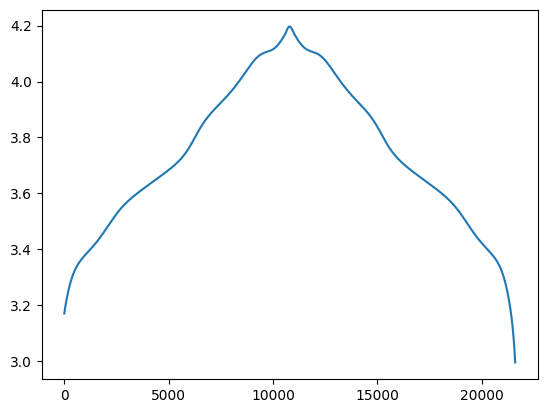

In [105]:
p = ParameterSet()
c = CurrentFunction(
    [0, 3*3600, 3*3600+1, 6*3600],  # Manual time
    [1, 1, -1, -1]                  # Manual current
    )

m = Model(p, c)

t, U = m.solve()
plt.plot(t, U)

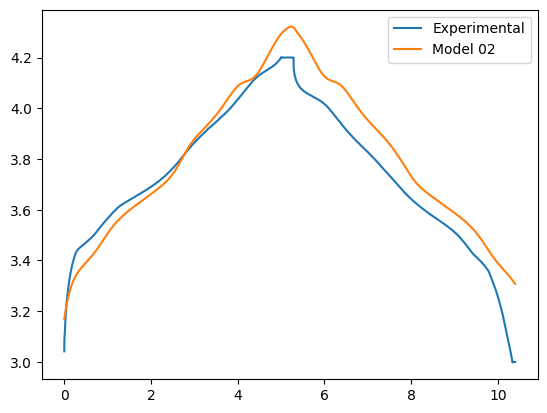

In [108]:
# At this point, I am ready to compare to BoL of my cell!
exp = np.genfromtxt('MJ1_01_01_C5.csv', delimiter=",", skip_header=1).T
exp[1] = exp[1]-exp[1][0]
exp_t, exp_u, exp_i = exp[1:4]

p = ParameterSet()
c = CurrentFunction(exp_t, exp_i)

m = Model(p, c)

t, U = m.solve()

plt.plot(exp_t/3600, exp_u, label="Experimental")
plt.plot(t/3600, U, label = "Model 02")
plt.legend()